In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

 ## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [2]:
#Load data into Pandas dataframe

In [3]:
#Read in files and print the information

train_feature_df = pd.read_csv("/Users/ashle/Downloads/DSDJ/Module 4/Salary Prediction/Salary Prediction Data/SalaryPredictions/data/train_features.csv")
train_target_df = pd.read_csv("/Users/ashle/Downloads/DSDJ/Module 4/Salary Prediction/Salary Prediction Data/SalaryPredictions/data/train_salaries.csv")
test_feature_df = pd.read_csv("/Users/ashle/Downloads/DSDJ/Module 4/Salary Prediction/Salary Prediction Data/SalaryPredictions/data/test_features.csv")

In [4]:
#Examine the data(automate-put in list)
lst = [train_feature_df, train_target_df, test_feature_df]
for data in lst:
    print(data.head(10))

              jobId companyId         jobType       degree      major  \
0  JOB1362684407687    COMP37             CFO      MASTERS       MATH   
1  JOB1362684407688    COMP19             CEO  HIGH_SCHOOL       NONE   
2  JOB1362684407689    COMP52  VICE_PRESIDENT     DOCTORAL    PHYSICS   
3  JOB1362684407690    COMP38         MANAGER     DOCTORAL  CHEMISTRY   
4  JOB1362684407691     COMP7  VICE_PRESIDENT    BACHELORS    PHYSICS   
5  JOB1362684407692    COMP15         MANAGER     DOCTORAL    COMPSCI   
6  JOB1362684407693    COMP15             CFO         NONE       NONE   
7  JOB1362684407694    COMP24          JUNIOR    BACHELORS  CHEMISTRY   
8  JOB1362684407695    COMP20         JANITOR  HIGH_SCHOOL       NONE   
9  JOB1362684407696    COMP41  VICE_PRESIDENT    BACHELORS  CHEMISTRY   

    industry  yearsExperience  milesFromMetropolis  
0     HEALTH               10                   83  
1        WEB                3                   73  
2     HEALTH               10        

### ---- 3 Clean the data ----

#### Goal: Look for duplicate data, invalid data, or corrupt data and remove it

##### First, Check for duplicates, put in loop

In [5]:
def chk_duplicate(df):
    lst = [train_feature_df, train_target_df, test_feature_df]
    for data in lst:
        data.duplicated().sum()

a = chk_duplicate(train_feature_df)
b = chk_duplicate(train_target_df)
c = chk_duplicate(test_feature_df)

print (('There are a total of {} duplicates for train dataset.'.format(a)))
print (('There are a total of {} duplicates for target dataset.'.format(b)))
print (('There are a total of {} duplicates for test dataset.'.format(c)))

There are a total of None duplicates for train dataset.
There are a total of None duplicates for target dataset.
There are a total of None duplicates for test dataset.


##### Verify there are no missing value in each dataset

In [6]:
def chk_missing(df):
    lst = [train_feature_df, train_target_df, test_feature_df]
    for data in lst:
        data.isnull().sum().sort_values(ascending=False).head()
    
a = chk_missing(train_feature_df)
b = chk_missing(train_target_df)
c = chk_missing (test_feature_df)

print (('There are a total of {} missing values for train dataset.'.format(a)))
print (('There are a total of {} missing values for target dataset.'.format(b)))
print (('There are a total of {} missing values for test dataset.'.format(c)))

There are a total of None missing values for train dataset.
There are a total of None missing values for target dataset.
There are a total of None missing values for test dataset.


### ---- 4 Explore the data (EDA) ----


In [7]:
#summarize each feature variable
#summarize the target variable
#look for correlation between each feature and the target
#look for correlation between features

##### Before we summarize each feature variable and the target variable, use .info() to see length and dtypes

In [8]:
lst = [train_feature_df, train_target_df, test_feature_df]
for data in lst:
    data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
jobId     1000000 non-null object
salary    1000000 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000

##### Based on the output above, identify numerical and categorical variables for train dataset. Prepare for analysis

In [12]:
def prep_train(df):
    df_feature_cat=['jobId', 'companyId', 'jobType','degree','major','industry']
    df_feature_num = ['yearsExperience', 'milesFromMetropolis']
    print(df.describe(include =[np.number]))
    print(df.describe(exclude = [np.number]))
    
prep_train(train_feature_df)

       yearsExperience  milesFromMetropolis
count   1000000.000000       1000000.000000
mean         11.992386            49.529260
std           7.212391            28.877733
min           0.000000             0.000000
25%           6.000000            25.000000
50%          12.000000            50.000000
75%          18.000000            75.000000
max          24.000000            99.000000
                   jobId companyId  jobType       degree    major industry
count            1000000   1000000  1000000      1000000  1000000  1000000
unique           1000000        63        8            5        9        7
top     JOB1362685209065    COMP39   SENIOR  HIGH_SCHOOL     NONE      WEB
freq                   1     16193   125886       236976   532355   143206


##### Merge the features and salaries on jobID, delete original file to save memory

In [13]:
train_df = pd.merge(train_feature_df,train_target_df, on='jobId')

In [14]:
del train_feature_df
del train_target_df

In [15]:
def new_df(df):
    print(df.head())
    print(df.describe(include =[np.number]))
    print(df.describe(exclude = [np.number]))
    print(df.info())
    
new_df(train_df)

              jobId companyId         jobType       degree      major  \
0  JOB1362684407687    COMP37             CFO      MASTERS       MATH   
1  JOB1362684407688    COMP19             CEO  HIGH_SCHOOL       NONE   
2  JOB1362684407689    COMP52  VICE_PRESIDENT     DOCTORAL    PHYSICS   
3  JOB1362684407690    COMP38         MANAGER     DOCTORAL  CHEMISTRY   
4  JOB1362684407691     COMP7  VICE_PRESIDENT    BACHELORS    PHYSICS   

  industry  yearsExperience  milesFromMetropolis  salary  
0   HEALTH               10                   83     130  
1      WEB                3                   73     101  
2   HEALTH               10                   38     137  
3     AUTO                8                   17     142  
4  FINANCE                8                   16     163  
       yearsExperience  milesFromMetropolis          salary
count   1000000.000000       1000000.000000  1000000.000000
mean         11.992386            49.529260      116.061818
std           7.212391     

### Visualize target variable (salary)

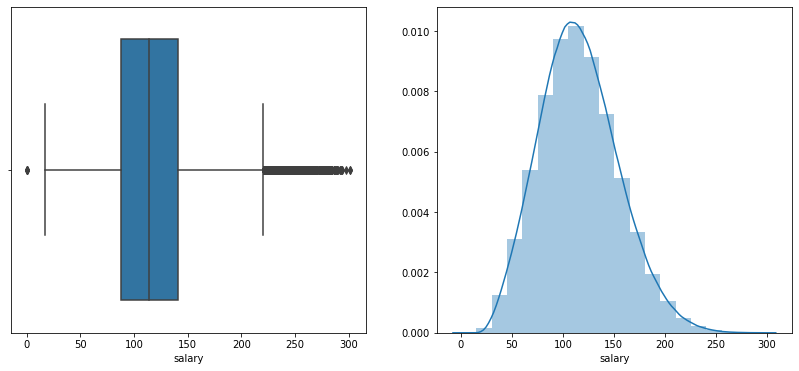

In [26]:
plt.figure(figsize = (14,6))
plt.subplot(1,2,1)
sns.boxplot(train_df['salary'])
plt.subplot(1,2,2)
sns.distplot(train_df['salary'], bins = 20)
plt.show()

### Use IQR rule to identify potential outliers
##### Create function 'dct_outliers' that will use IQR to identify potential outliers

In [16]:
def dct_outliers (df, col):
    stat = df[col].describe()
    print(stat)
    IQR = stat['75%'] - stat['25%']
    upper = stat['75%'] + 1.5 * IQR
    lower = stat['25%'] - 1.5 * IQR
    print('The upper and lower bounds for suspected outliers are {} and {}.'.format(upper,lower))

dct_outliers(train_df, 'salary')

count    1000000.000000
mean         116.061818
std           38.717936
min            0.000000
25%           88.000000
50%          114.000000
75%          141.000000
max          301.000000
Name: salary, dtype: float64
The upper and lower bounds for suspected outliers are 220.5 and 8.5.


###### Examine potential outliers

In [17]:
#check potential outliers below lower bound
train_df[train_df['salary'] < 8.5]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


In [18]:
train_df.loc[train_df['salary'] < 8.5,'jobType'].value_counts()

JUNIOR            2
VICE_PRESIDENT    1
CTO               1
MANAGER           1
Name: jobType, dtype: int64

In [19]:
#check potential outlier above upper bound
train_df[train_df['salary'] > 220.5].describe()

,yearsExperience,milesFromMetropolis,salary
count,7117.000000,7117.000000,7117.000000
mean,20.004496,20.815653,234.539413
std,3.867752,18.110057,12.433704
min,0.000000,0.000000,221.000000
25%,18.000000,7.000000,225.000000
50%,21.000000,16.000000,231.000000
75%,23.000000,30.000000,241.000000
max,24.000000,98.000000,301.000000


In [33]:
#check potential outlier abover upper bound
train_df.loc[train_df['salary'] > 220.5, 'jobType'].value_counts()

CEO               3227
CFO               1496
CTO               1488
VICE_PRESIDENT     603
MANAGER            217
SENIOR              66
JUNIOR              20
Name: jobType, dtype: int64

In [34]:
train_df[(train_df['salary'] > 220.5) & (train_df['jobType'] == 'JUNIOR')]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
1222,JOB1362684408909,COMP40,JUNIOR,MASTERS,COMPSCI,OIL,24,5,225
27710,JOB1362684435397,COMP21,JUNIOR,DOCTORAL,ENGINEERING,OIL,24,3,246
31355,JOB1362684439042,COMP45,JUNIOR,DOCTORAL,COMPSCI,FINANCE,24,0,225
100042,JOB1362684507729,COMP17,JUNIOR,DOCTORAL,BUSINESS,FINANCE,23,8,248
160333,JOB1362684568020,COMP18,JUNIOR,DOCTORAL,BUSINESS,FINANCE,22,3,223
189582,JOB1362684597269,COMP32,JUNIOR,DOCTORAL,BUSINESS,OIL,24,11,221
214606,JOB1362684622293,COMP47,JUNIOR,MASTERS,BUSINESS,FINANCE,22,4,222
303778,JOB1362684711465,COMP51,JUNIOR,MASTERS,ENGINEERING,WEB,24,2,226
348354,JOB1362684756041,COMP56,JUNIOR,DOCTORAL,ENGINEERING,OIL,23,25,226
427593,JOB1362684835280,COMP54,JUNIOR,DOCTORAL,ENGINEERING,FINANCE,23,3,221


*** These entries with zero salary do not appear to be volunteer. We are confident that they are instaces of missing/corrupt data and should be removed from the training set.

*** The high-salary potential outliers all appear to be legitmate data. Most roles are C-level executive roles and the junior positions are in industries that are well known for high salaries(oil, finance). We determine these entries to be legitimate and will not remove them.

In [36]:
#Remove data with zero salaries
train_df = train_df[train_df['salary'] > 8.5]

In [37]:
def plot_feature(df, col):
    '''
    Make plot for each features
    left, the distribution of samples on the feature
    right, the dependance of salary on the feature
    '''
    plt.figure(figsize = (14, 6))
    plt.subplot(1, 2, 1)
    if df[col].dtype == 'int64':
        df[col].value_counts().sort_index().plot()
    else:
        #change the categorical variable to category type and order their level by the mean salary
        #in each category
        mean = df.groupby(col)['salary'].mean()
        df[col] = df[col].astype('category')
        levels = mean.sort_values().index.tolist()
        df[col].cat.reorder_categories(levels, inplace=True)
        df[col].value_counts().plot()
    plt.xticks(rotation=45)
    plt.xlabel(col)
    plt.ylabel('Counts')
    plt.subplot(1, 2, 2)

    if df[col].dtype == 'int64' or col == 'companyId':
        #plot the mean salary for each category and fill between the (mean - std, mean + std)
        mean = df.groupby(col)['salary'].mean()
        std = df.groupby(col)['salary'].std()
        mean.plot()
        plt.fill_between(range(len(std.index)), mean.values-std.values, mean.values + std.values, \
                         alpha = 0.1)
    else:
        sns.boxplot(x = col, y = 'salary', data=df)
    
    plt.xticks(rotation=45)
    plt.ylabel('Salaries')
    plt.show()

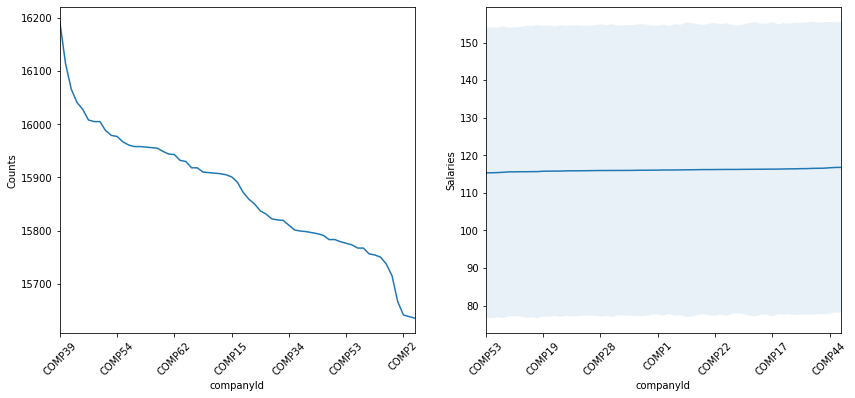

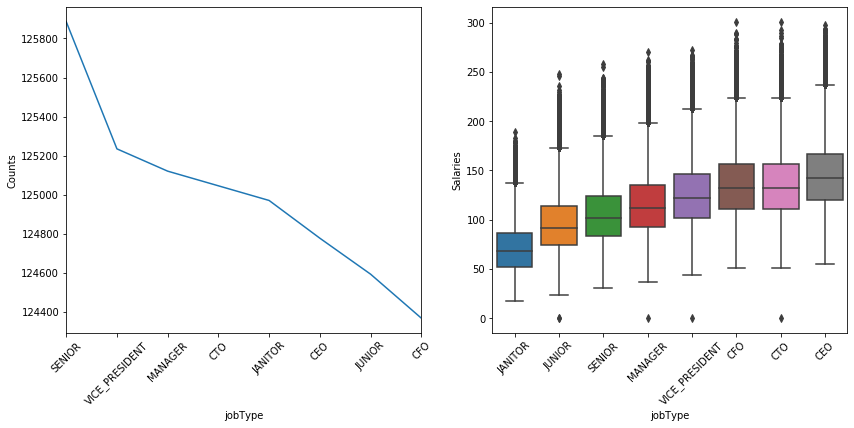

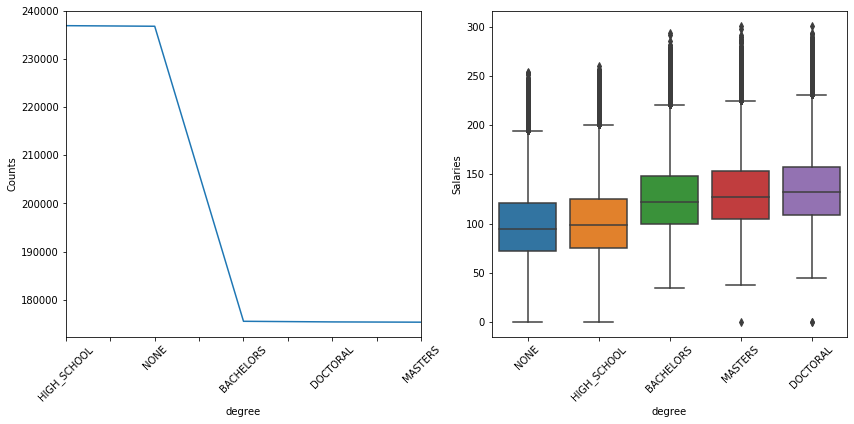

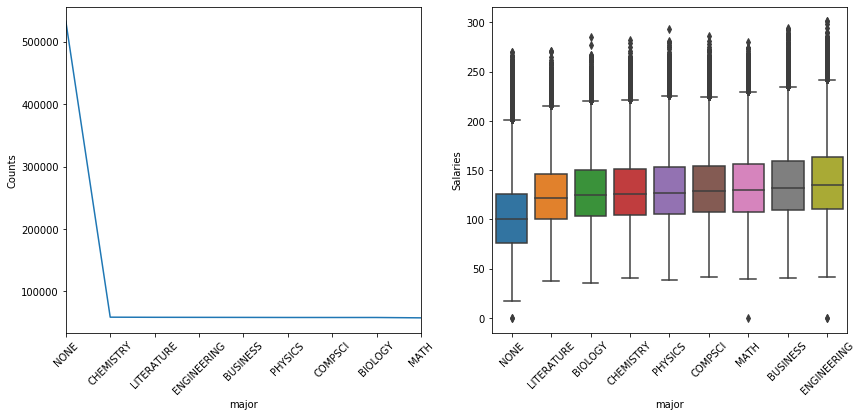

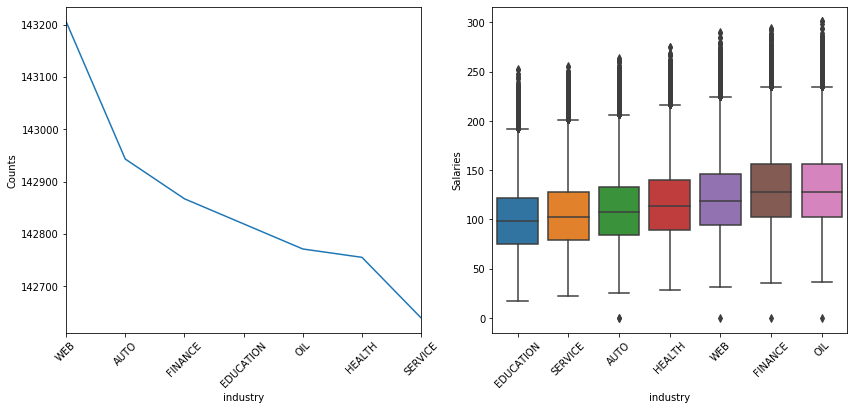

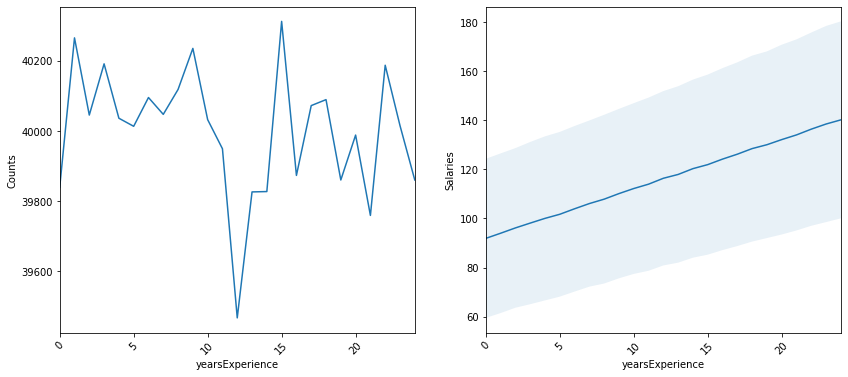

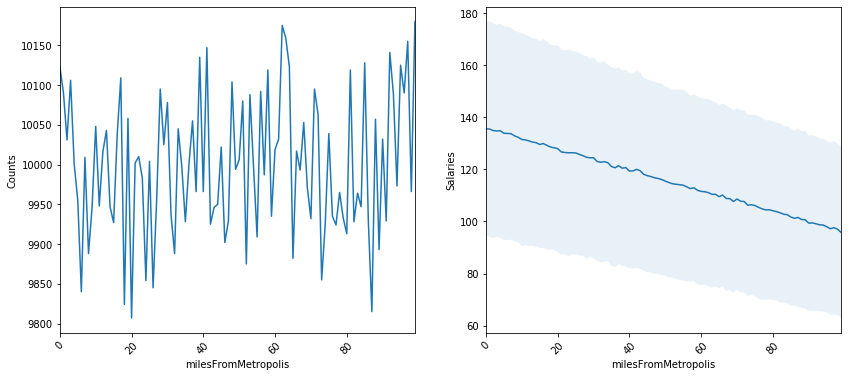

In [34]:
lst = ['companyId', 'jobType', 'degree','major','industry','yearsExperience','milesFromMetropolis']
for data in lst:
    plot_feature(train_df, data)

***** The salary is weakly associated with companies. There is a clear positive correlation between job type and salary. People with majors of engineering, business and math generally have higher salaries. As for industries, oil, finance and web industries generally pay better. In general, there is a clear correlation between salary and years of experience. In general, salaries decrease with the distance to metropolis.

In [59]:
def encode_label(df, col):
    #encode the categories using average salary for each category to replace label
    cat_dict ={}
    cats = df[col].cat.categories.tolist()
    for cat in cats:
        cat_dict[cat] = train_df[train_df[col] == cat]['salary'].mean()   
    df[col] = df[col].map(cat_dict)

In [41]:
for col in train_df.columns:
    if train_df[col].dtype.name == "category":
        encode_label(train_df, col)

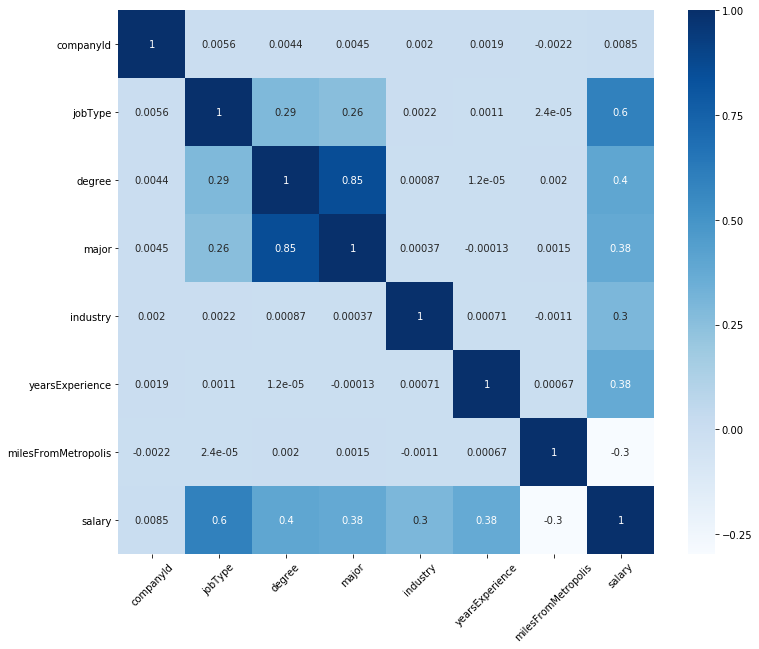

In [42]:
# Correlations between selected features and response
# jobId is discarded because it is unique for individual
fig = plt.figure(figsize=(12, 10))
features = ['companyId', 'jobType', 'degree', 'major', 'industry', 'yearsExperience', 'milesFromMetropolis']
sns.heatmap(train_df[features + ['salary']].corr(), cmap='Blues', annot=True)
plt.xticks(rotation=45)
plt.show()